# Case study 2: Sentiment Analysis with CNN Models


Sentiment analysis is one of the most widely performed analysis on text data. Sentiment analysis has been through tremendous improvements from the days of classic methods to recent times where in the state of the art models utilize deep learning to improve the performance.

Convolutional Neural Networks or CNNs have brought deep learning research into mainstream discussions, especially on image classification and image and video recognition.

In this case study, we will perform sentiment analysis using a CNN in a dataset of 50,000 movie reviews (IMDB dataset that you can found on Kaggle at https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [2]:
%pip install tqdm
import nltk
nltk.download('punkt')

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: colorama in c:\users\apala\appdata\roaming\python\python310\site-packages (from tqdm) (0.4.4)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Import dataset 

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproductibility
seed = 42
np.random.seed(seed)

In [6]:
dataset = pd.read_csv('IMDB Dataset.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
dataset['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [9]:
dataset['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [10]:
# Split the dataset between train set and test set
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

## Data pre-processing

In [12]:
from bs4 import BeautifulSoup # Beautiful Soup is a Python library for pulling data out of HTML and XML files.
import numpy as np
import re # To handle regular expression
import tqdm # Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you’re done!
import unicodedata

# Function to remove html tags 
#Beautiful Soup is a Python library for pulling data out of HTML and XML files. 
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

# Function to remove accents
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

# Function to remove html tags
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A) #Replace anything except 0..9, a..z and A..Z
    doc = re.sub(' +', ' ', doc) #remove +
    doc = doc.strip()  #remove whitespaces
    norm_docs.append(doc)
  
  return norm_docs

In [13]:
print (unicodedata.normalize('NFKD', u'\u2460'))
print(unicodedata.normalize('NFKD', 'Cécile').encode('ascii', 'ignore').decode('utf-8', 'ignore'))

1
Cecile


In [14]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:09<00:00, 1566.85it/s]

CPU times: total: 31.2 s
Wall time: 31.5 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [15]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents of the train set
t.fit_on_texts(norm_train_reviews)
# will be useful for padding (see later)
t.word_index['<PAD>'] = 0

In [16]:
# Example of what the instance tokenizer does to text data
print(t.texts_to_sequences(['I love deep learning']))

[[11, 110, 849, 2873]]


In [17]:
# Outputs are: the word with the maximum token value, the word with the minimum token value
# and the token value when the word is unknown (i.e. not in the train set vocabulary)
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 176790), ('<PAD>', 0), 1)

In [18]:
# token value if word=<PAD>
t.word_index['<PAD>']

0

In [19]:
# token value if word is unknown
t.word_index['<UNK>']

1

In [20]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [21]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [22]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=176791
Number of Documents=35000


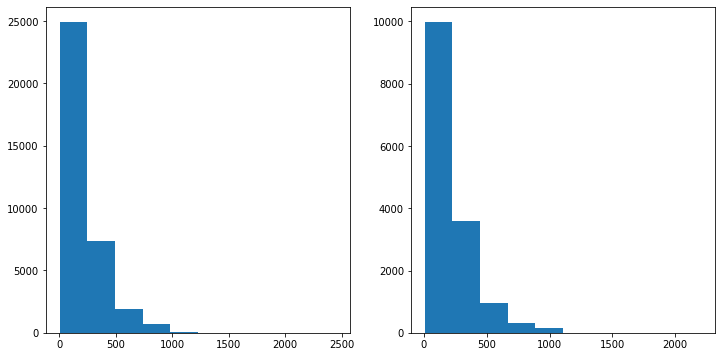

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [24]:
MAX_SEQUENCE_LENGTH = 1000

In [25]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

In [26]:
# Example of what pad_sequences function does
text_to_sequence_example=t.texts_to_sequences(['I love deep learning azertyyyyy'])
print(text_to_sequence_example)
print(sequence.pad_sequences(text_to_sequence_example, maxlen=MAX_SEQUENCE_LENGTH))

[[11, 110, 849, 2873, 1]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [27]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [28]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [29]:
VOCAB_SIZE = len(t.word_index)

In [30]:
VOCAB_SIZE

176791

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [31]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [32]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         53037300  
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)           8

## Model Training

In [33]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
247/247 [==============================] - 514s 2s/step - loss: 0.4141 - accuracy: 0.7692 - val_loss: 0.2476 - val_accuracy: 0.8986
Epoch 2/2
247/247 [==============================] - 494s 2s/step - loss: 0.1336 - accuracy: 0.9514 - val_loss: 0.2573 - val_accuracy: 0.9023


## Model Evaluation

In [139]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 13s 28ms/step - loss: 0.2731 - accuracy: 0.8960
Accuracy: 89.60%


In [47]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [48]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.93      0.86      0.89      7490
    positive       0.87      0.93      0.90      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6477,1013
positive,511,6999


## Examples of reviews wrongly classified

In [153]:
incorrects = np.nonzero(predictions != test_sentiments)

In [167]:
incorrects

(array([    9,    32,    38, ..., 14958, 14975, 14993], dtype=int64),)

In [177]:
incorrects[0][200]

2146

In [179]:
print(test_reviews[14958],'||',test_sentiments[14958])

As someone who loves baseball history, especially the early 20th century in which Cobb was a main figure, along with a ton of colorful characters, I was looking forward to seeing this baseball film. Well, it wasn't a baseball film, which was disappointing. No, it was just a sportswriter's account of being with Cobb in the ballplayer's later years while the two collaborated on a book. Even at that, this could have been a more appealing movie than they made it.<br /><br />Granted Cobb was anything but a nice guy, an extremely talented player but brutal in that he would do anything to beat you....and he was viscous, intimidating and had a lot of demons to fight. He was so hated his own teammates tried to hinder his chances of winning a batting title one year. Nonetheless, this an over-the-top portrayal of the man. It makes him into something almost cartoon-like. <br /><br />Watching and listening to an old man rant, rave and profane for two hours is entertainment? No, it isn't. Some day, 

In [178]:
print(test_reviews[2146],'||',test_sentiments[2146])

I contend that whoever is ultimately responsible for creating/approving the trailer for this movie has completely blundered. NO ONE I know wanted to see this movie based on the previews, and EVERYONE who actually saw it (that I know) absolutely loved it... The advertising campaign is disgrace/disaster/blunder.<br /><br />Opened at #4 behind...<br /><br />#1-Rush Hour, which I have not seen, average IMDb score of 7.4.<br /><br />#2-The Bourn Ultimatum, which I have seen, awesome movie but 3rd week out, average IMDb score of 8.7 (deserving I would say).<br /><br />#3-The Simpsons Movie, which I have seen, okay movie but 4th week out, average IMDb score of 8.1 (a bit high in my opinion).<br /><br />#4-Stardust, average IMDb score of 8.4 (lower then Bourn, but that's been our for 3 weeks).<br /><br />Whether it was poor scheduling or poor advertising I think that the powers that be behind this movie screwed up big time! This should have been advertised as an amazing movie that happens to b

In [173]:
print(test_reviews[135],'||',test_sentiments[135])

I saw the film at the Belgrade Film Festival last week, and I'm still working off the trauma. Essentially my view seems to match a number of others - the first half hour was fresh, sharp, deep, entertaining and promising. Well acted too. Natural. My problem, however, is not simply with the fact that the final hour and a half of the film have nothing to do with the likable beginning, nor the fact that I spent most of this time convulsing in agony at sharp, grating industrial sounds and squinting at drunken, toothless, bread-chewing hags. It's rather with the fact that THEY NEVER WARNED ME!!! The festival brochure synopsis described only the (utterly intriguing-sounding) first half hour - a whore, piano tuner and meat seller chat in a bar, pretending to be an advertising agent, genetic engineer, and petty government administration official, respectively - making no mention whatsoever of the never-ending gum-smacking to come. Serves me right for not reading the reviews, you might say - bu

In [181]:
print(test_reviews[9],'||',test_sentiments[9])

A charming boy and his mother move to a middle of nowhere town, cats and death soon follow them. That about sums it up.<br /><br />I'll admit that I am a little freaked out by cats after seeing this movie. But in all seriousness in spite of the numerous things that are wrong with this film, and believe me there is plenty of that to go around, it is overall a very enjoyable viewing experience.<br /><br />The characters are more like caricatures here with only their basis instincts to rely on. Fear, greed, pride lust or anger seems to be all that motivate these people. Although it can be argued that that seeming failing, in actuality, serves the telling of the story. The supernatural premise and the fact that it is a Stephen King screenplay(not that I have anything specific against Mr. King) are quite nicely supported by some interesting FX work, makeup and quite suitable music. The absolute gem of this film is without a doubt Alice Krige who plays Mary Brady, the otherworldly mother.<br